In [5]:
import jax
import jax.numpy as jnp
from jax import Array
from ml_collections import config_flags
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ddprism.corrupted_mnist import datasets
from ddprism.metrics import metrics, image_metrics
from ddprism.corrupted_mnist import config_base_grass
from ddprism.corrupted_mnist import config_base_mnist

import clvm

import math
from typing import Any, Callable, Mapping, Sequence, Tuple, Optional
from einops import rearrange

from tqdm import tqdm
import optax
from flax import linen as nn
from flax.training import train_state, orbax_utils

from ddprism import utils
from ddprism import plotting_utils

from ddprism.rand_manifolds.scaling_n_models import load_dataset, config_base_pcpca
import matplotlib.pyplot as plt

In [6]:
imagenet_path = '/mnt/home/aakhmetzhanova/ceph/galaxy-diffusion/corrupted-mnist/dataset/grass_jpeg/' 


## 1. Load dataset

(65536, 3, 5) (65536, 3, 3, 5) (65536, 3, 3)


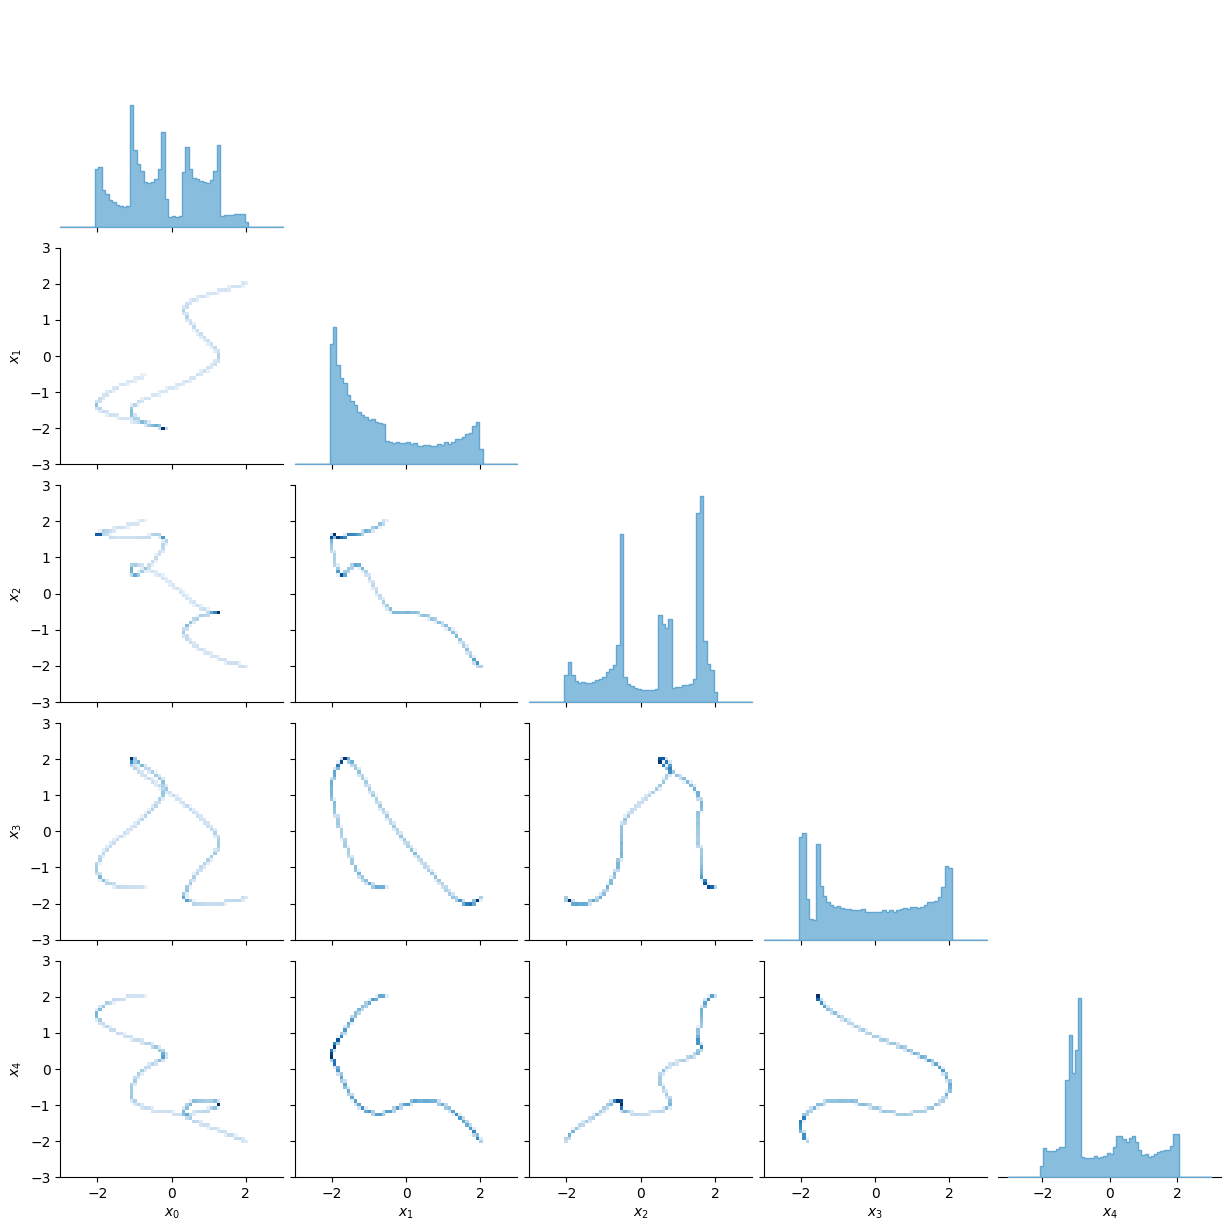

In [12]:
# Load base configuration file
config = config_base_pcpca.get_config()

# Get random key.
rng = jax.random.PRNGKey(config.rng_key)

# Generate our dataset.
rng, rng_data = jax.random.split(rng)
x_all, A_all, y_all, _ = load_dataset.get_dataset(rng_data, config)
print(x_all.shape, A_all.shape, y_all.shape,)

fig = plotting_utils.show_corner(x_all[:, 0])._figure

### 1.1 Check on the case with 2 sources

In [22]:
config.obs_dim, config.feat_dim, x_all.shape, y_all.shape, A_all.shape

(3, 5, (65536, 3, 5), (65536, 3, 3), (65536, 3, 3, 5))

In [36]:
features   = config.feat_dim

tg  = y_all[:, 1].reshape(-1, config.obs_dim)
bkg = y_all[:, 0].reshape(-1, config.obs_dim)

a_mat_tg  = A_all[:, 1]
a_mat_bkg = A_all[:, 0]

## 2. Create cLVM model

### 2.1 Define encoder, decoder, and VAE modules

In [84]:
import models

In [85]:
import importlib
importlib.reload(clvm)
importlib.reload(models)

<module 'models' from '/mnt/home/aakhmetzhanova/ddprism/ddprism/rand_manifolds/scaling_n_models/clvm/models.py'>

In [86]:
@jax.jit
def update_model(state, grads):
    """Update model with gradients."""
    return state.apply_gradients(grads=grads)

@jax.jit
def apply_model(rng, state, x, y, a_mat_x, a_mat_y, sigma_noise):
    """Computes gradients and loss for a single batch."""

    # loss
    def loss_fn(params):
        # Draw samples in data space.
        x_draws, y_draws, latent_params = state.apply_fn(
            {'params': params}, rng, x, y, a_mat_x, a_mat_y,
        )
        mu_tx, log_sigma_tx, mu_zx, log_sigma_zx, mu_zy, log_sigma_zy = latent_params
        
        # Compute loss function
        # Reconstruction loss
        loss = (optax.losses.squared_error(x, x_draws).sum(axis=-1) / 2 / sigma_noise**2)
        loss += (optax.losses.squared_error(y, y_draws).sum(axis=-1) / 2 / sigma_noise**2)
        loss = loss.mean()
        #jax.debug.print("loss: {loss}", loss=loss)
        
        # Prior loss
        kl_div = ((mu_tx**2 + jnp.exp(log_sigma_tx*2) - 2*log_sigma_tx) / 2).sum(axis=-1)
        kl_div += ((mu_zx**2 + jnp.exp(log_sigma_zx*2) - 2*log_sigma_zx) / 2).sum(axis=-1)
        kl_div += ((mu_zy**2 + jnp.exp(log_sigma_zy*2) - 2*log_sigma_zy) / 2).sum(axis=-1)
        
        kl_div = kl_div.mean()
        #jax.debug.print("kl_div: {kl_div}", kl_div=kl_div)
        
        loss = loss + kl_div
        return loss
    
    grad_fn = jax.value_and_grad(loss_fn,)
    loss, grads = grad_fn(state.params)

    return grads, loss

In [87]:
rng = jax.random.key(0)
rng, rng_state = jax.random.split(rng, 2)

latent_dim_tg, latent_dim_bkg = 5, 5
hid_features = (128, 256)

encoder_tg = models.encoder_MLP(latent_dim_tg, hid_features=hid_features)
decoder_tg = models.decoder_MLP(features, hid_features=hid_features[::-1])
cvae_tg = models.cVAE(encoder_tg, decoder_tg)

encoder_bkg = models.encoder_MLP(latent_dim_bkg, hid_features=hid_features)
decoder_bkg = models.decoder_MLP(features, hid_features=hid_features[::-1])
cvae_bkg = models.cVAE(encoder_bkg, decoder_bkg)

clvm_model = clvm.clvmVAE(cvae_bkg, cvae_tg)
params_clvm = clvm_model.init(
    rng, rng_state, 
    jnp.ones((1, config.obs_dim)), jnp.ones((1,  config.obs_dim)),
    jnp.ones((1, 1, config.obs_dim, config.feat_dim)), 
    jnp.ones((1, 1, config.obs_dim, config.feat_dim))
)

sigma_noise = config.sigma_y

# Training setup.
learning_rate = 1e-3
epochs = 10
batch_size = 128

tg_dset_size = target.shape[0]
bkg_dset_size = background.shape[0]
steps_per_epoch = tg_dset_size // batch_size

learning_rate_fn = optax.cosine_decay_schedule(
        init_value=learning_rate, decay_steps=epochs*steps_per_epoch
    )
tx = optax.adam(learning_rate=learning_rate_fn)

state = train_state.TrainState.create(apply_fn=clvm_model.apply, 
                                      params=params_clvm['params'], 
                                      tx=tx)

  0%|          | 0/10 [00:25<?, ?it/s, loss=2958.218] 

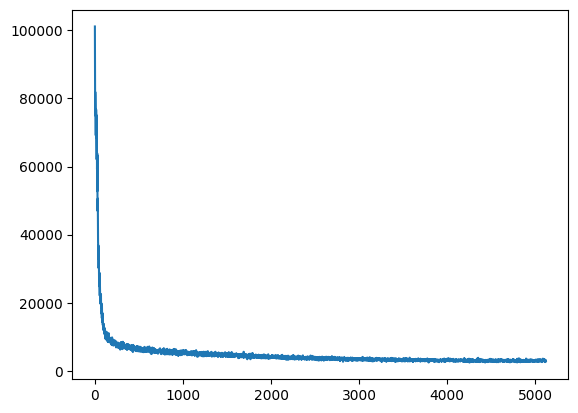

In [88]:
losses_per_epoch = []

pbar = tqdm(range(epochs),)

for epoch in range(epochs):
    losses = []
    #print(epoch)
    
    for step in range(steps_per_epoch):
        # Get a random batch.
        rng_epoch, rng_tg, rng_bkg, rng = jax.random.split(rng, 4)
        batch_tg = jax.random.randint(rng_tg, shape=(batch_size,), minval=0, maxval=tg_dset_size)
        batch_bkg = jax.random.randint(rng_bkg, shape=(batch_size,), minval=0, maxval=bkg_dset_size)

        
        # Compute gradients and losses.
        grads, loss = apply_model(
            rng_epoch, state, target[batch_tg], background[batch_bkg], 
            a_mat_tg[batch_tg], a_mat_bkg[batch_bkg],
            sigma_noise=sigma_noise
        )
        state = update_model(
                        state, grads
        )
        losses.append(loss)
    
    losses_per_epoch.append(losses)
    pbar.set_postfix({'loss': f'{jnp.asarray(losses).mean():.3f}'})
    
losses_per_epoch = jnp.concatenate(jnp.asarray(losses_per_epoch))
plt.plot(losses_per_epoch)

In [89]:
rng_samples, rng = jax.random.split(rng)
y2_samples, y1_samples, latents = state.apply_fn(
    {'params': state.params}, rng_samples, 
    target, background, a_mat_tg, a_mat_bkg
)

y2_samples.shape, y1_samples.shape


((65536, 3), (65536, 3))

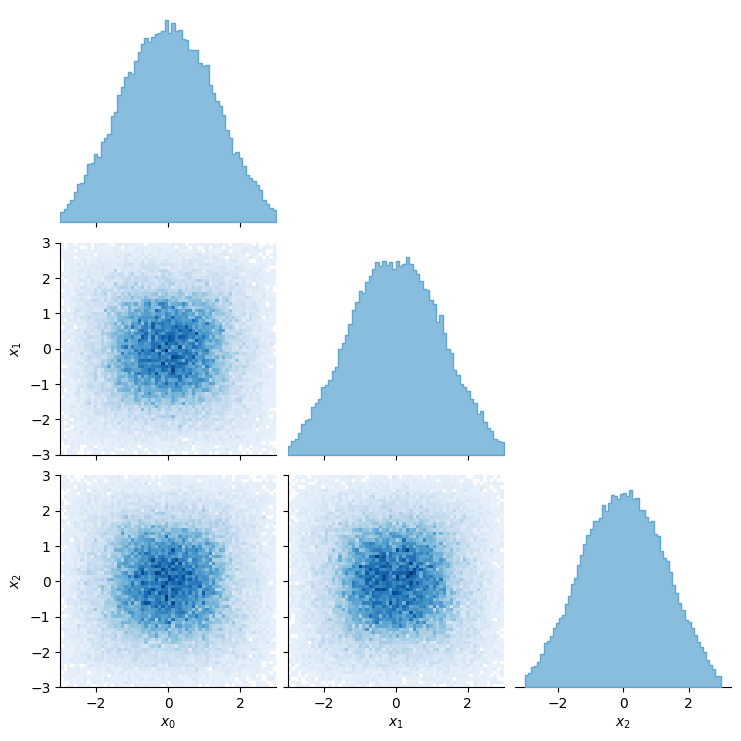

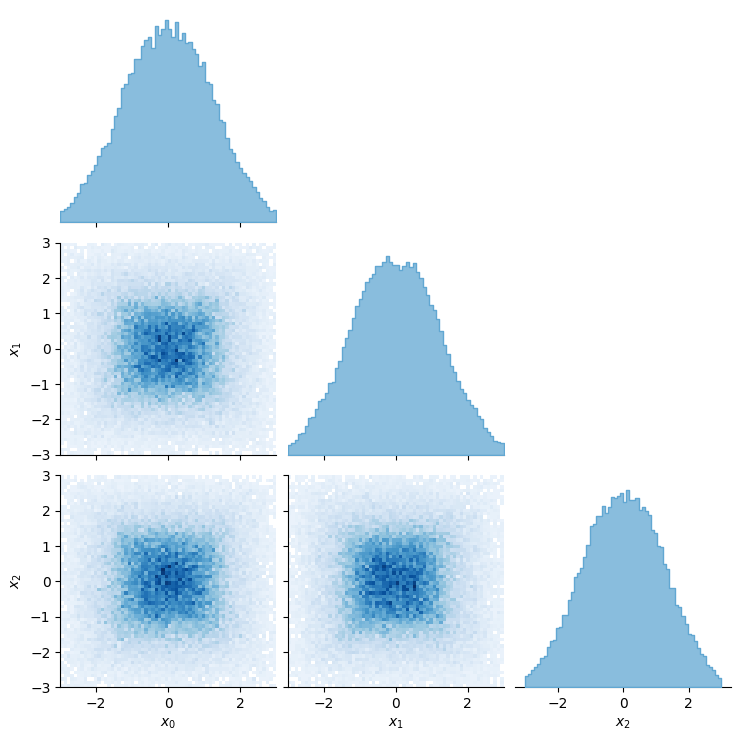

In [90]:
fig = plotting_utils.show_corner(y_all[:, 0])._figure

fig = plotting_utils.show_corner(y1_samples)._figure

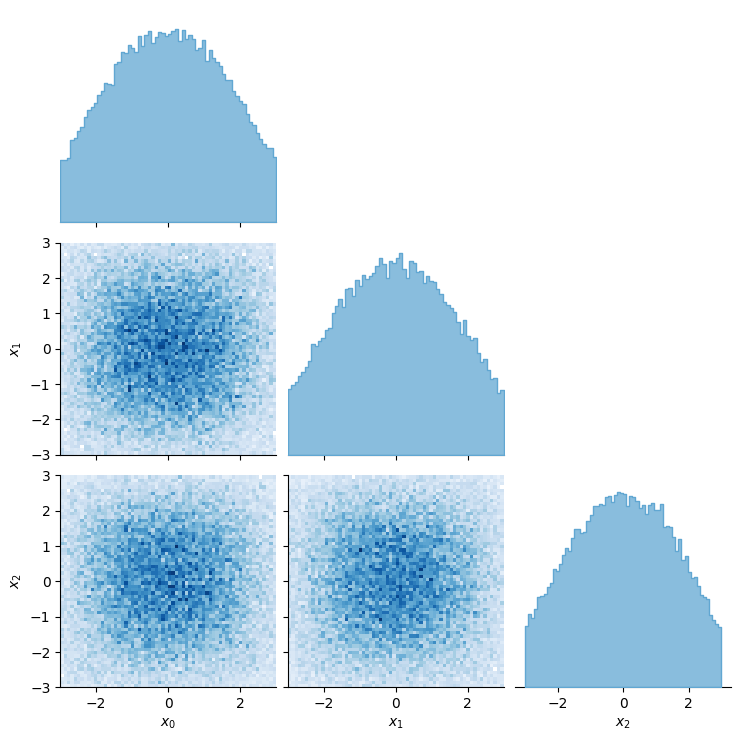

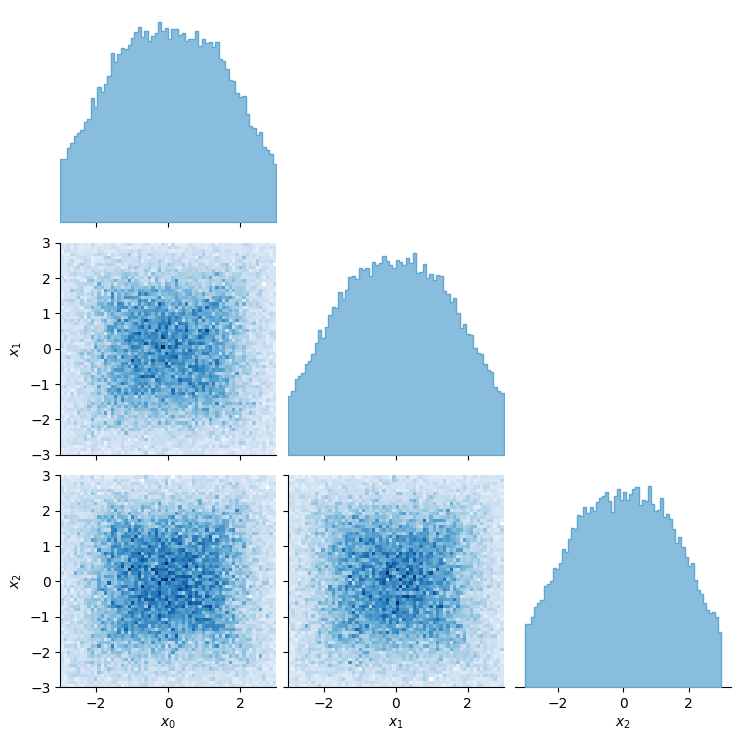

In [91]:
fig = plotting_utils.show_corner(y_all[:, 1])._figure

fig = plotting_utils.show_corner(y2_samples)._figure

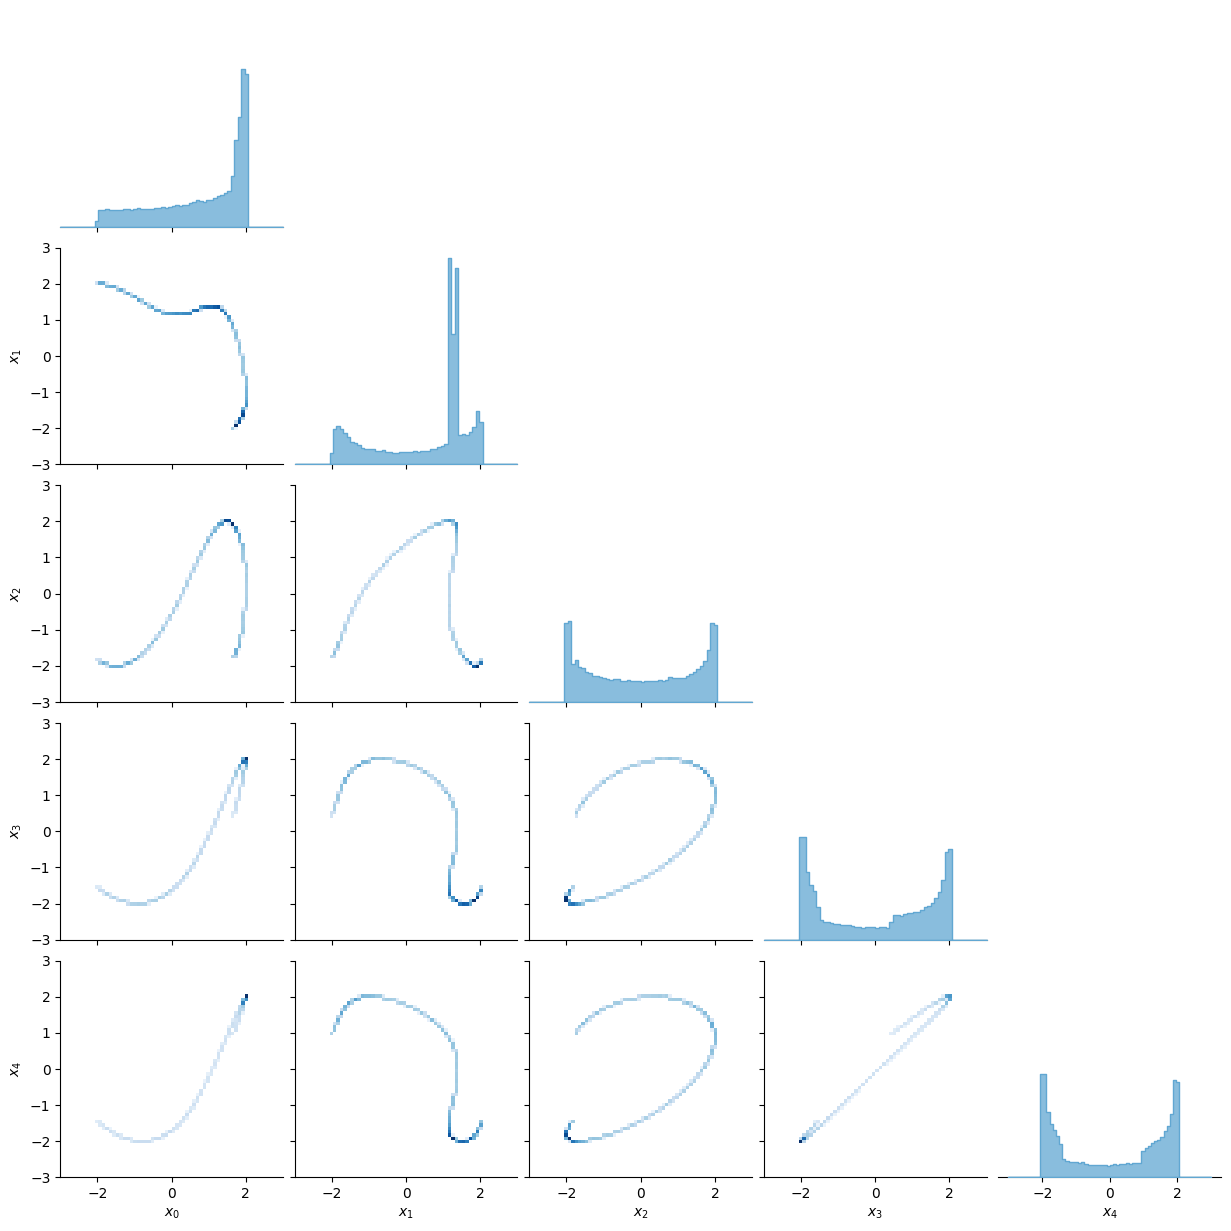

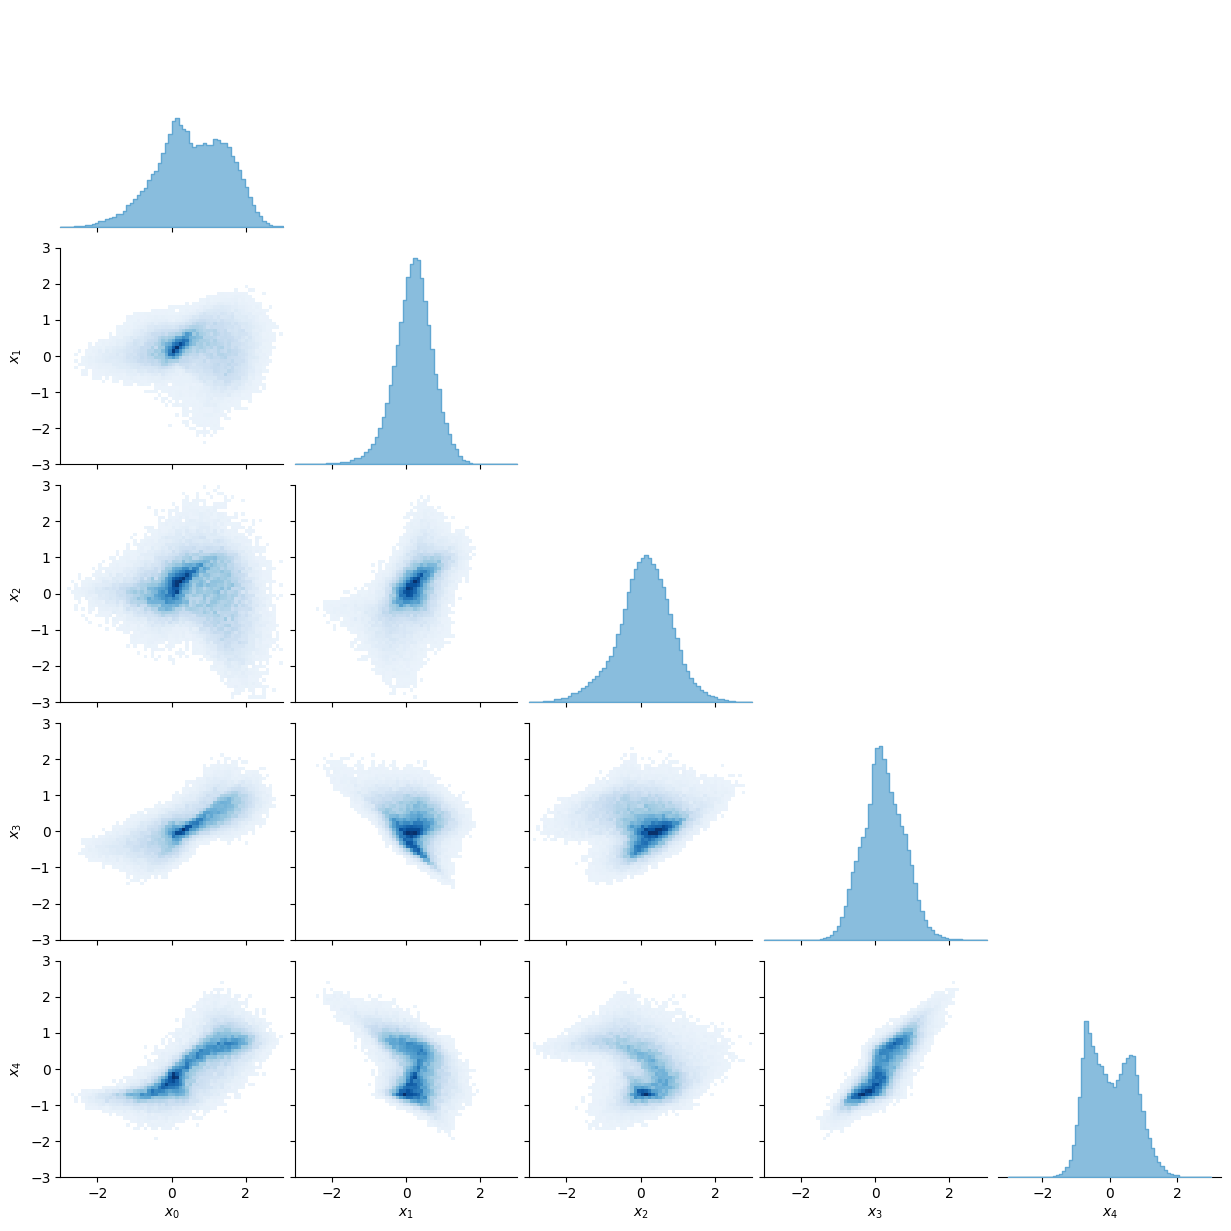

In [92]:
rng_samples, rng = jax.random.split(rng)
target_denoised = state.apply_fn({'params': state.params}, 
                                 rng_samples, target, a_mat_tg,
                                 method="denoise_samples")

fig = plotting_utils.show_corner(x_all[:, 1])._figure

fig = plotting_utils.show_corner(target_denoised)._figure

  0%|          | 0/100 [14:22<?, ?it/s, loss=741.703]


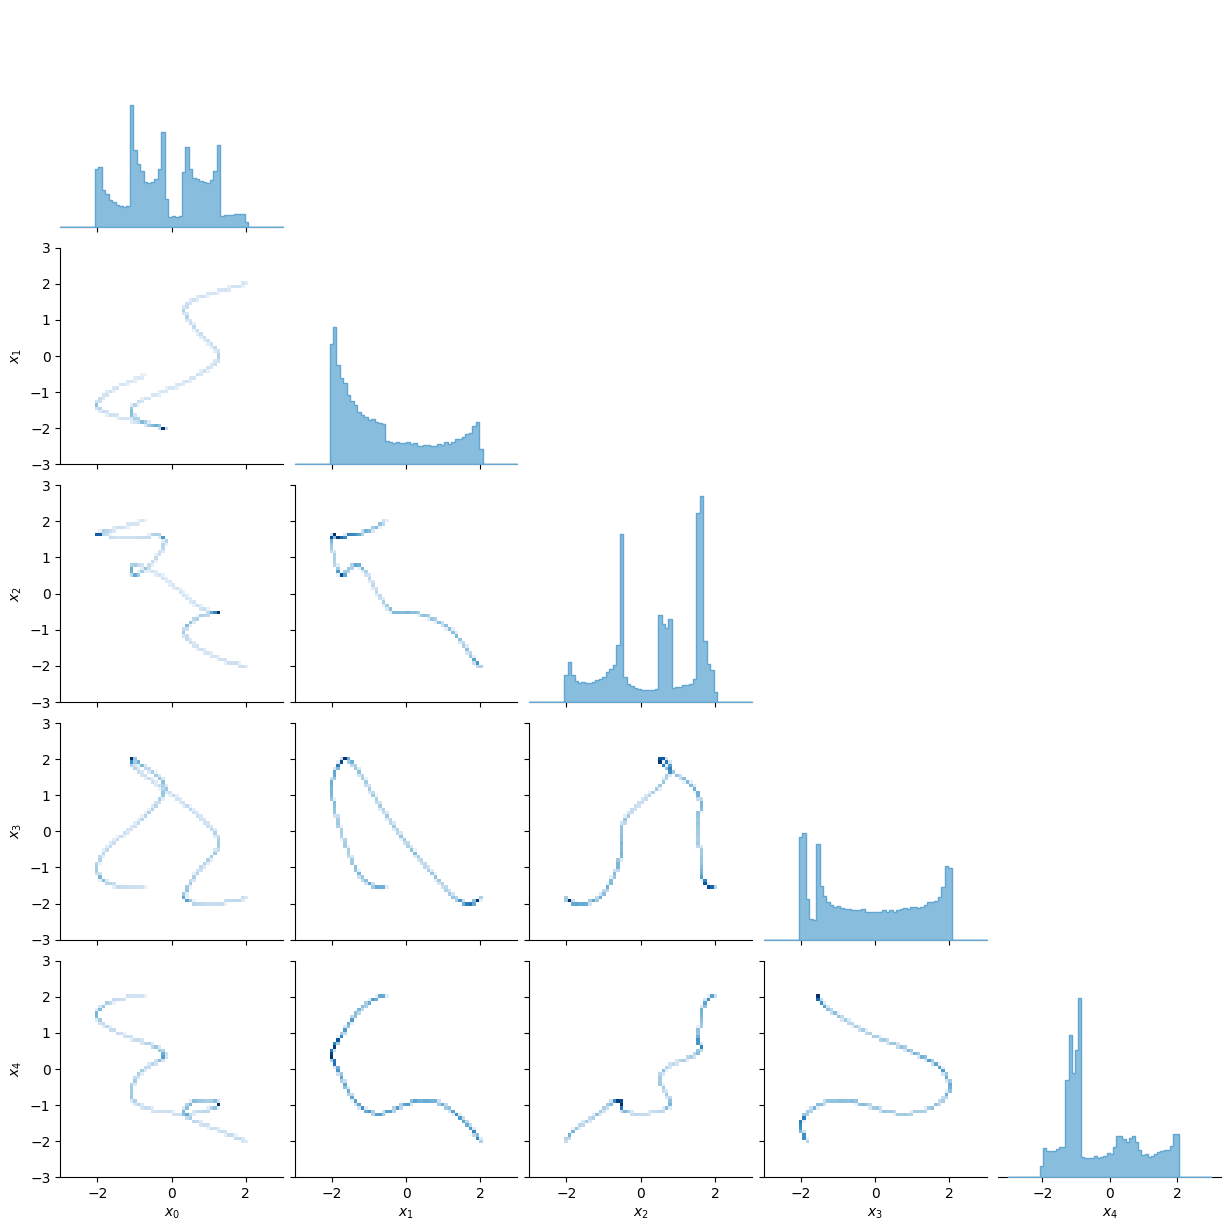

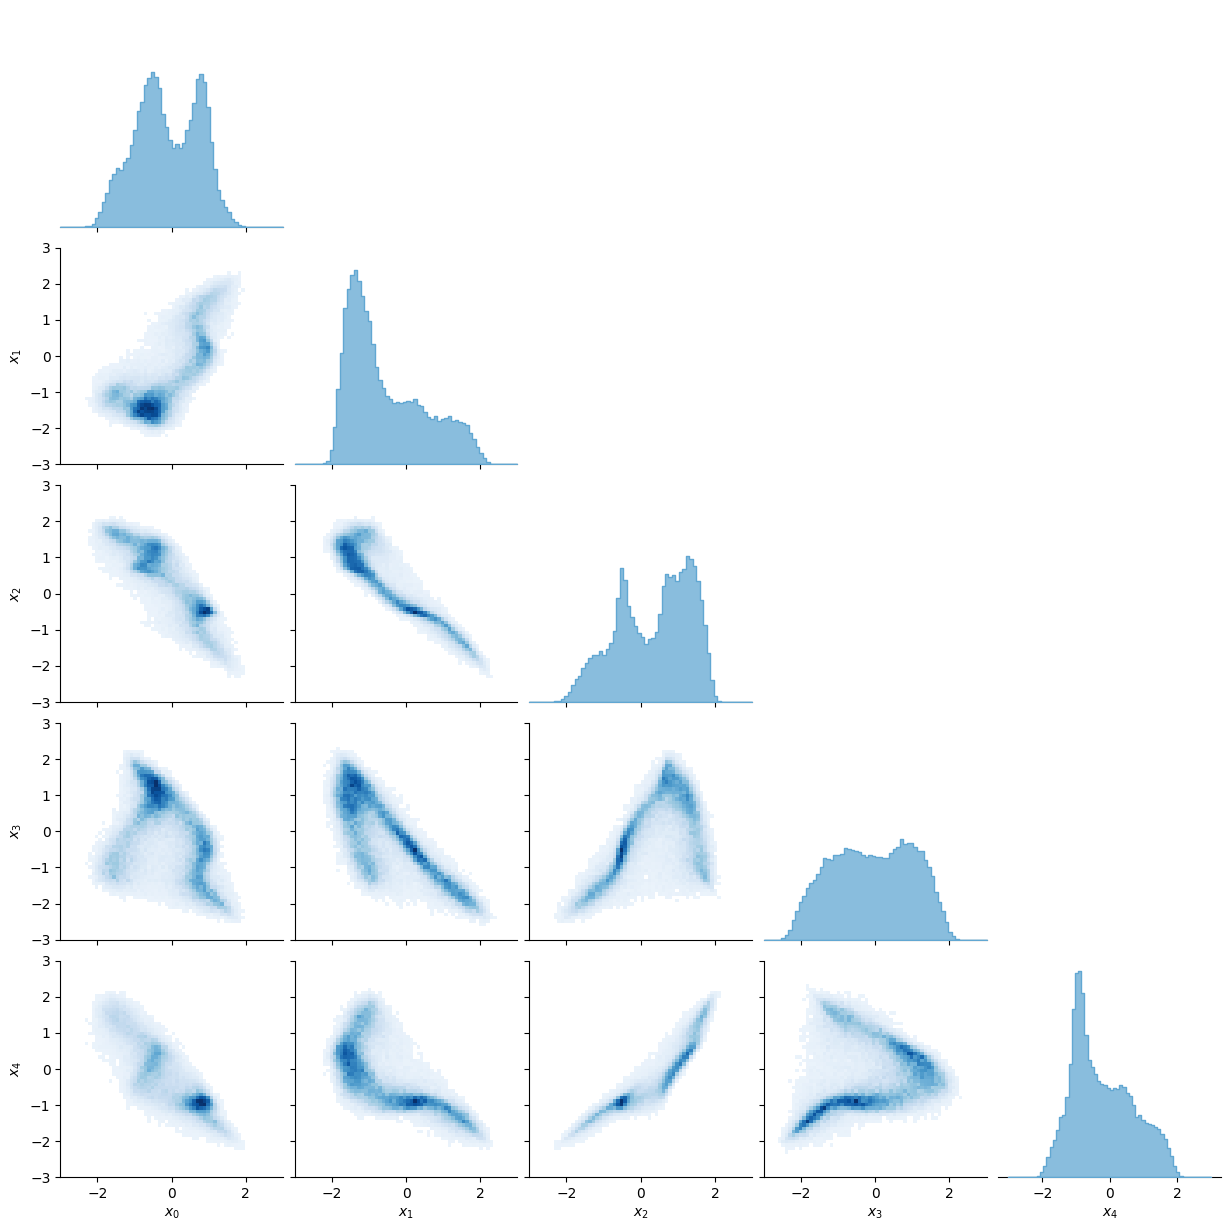

In [93]:
rng_samples, rng = jax.random.split(rng)
background_denoised = state.apply_fn({'params': state.params}, 
                                 rng_samples, background, a_mat_bkg, 
                                     dset='background',
                                 method="denoise_samples")

fig = plotting_utils.show_corner(x_all[:, 0])._figure

fig = plotting_utils.show_corner(background_denoised)._figure